# Homework assignment for ARIA image course 

In [2]:
import torch 
import torchvision.transforms.v2 as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Model trained on a mac arm GPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), 
    transforms.Normalize((0.5,), (0.5,))
    ])

In [4]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

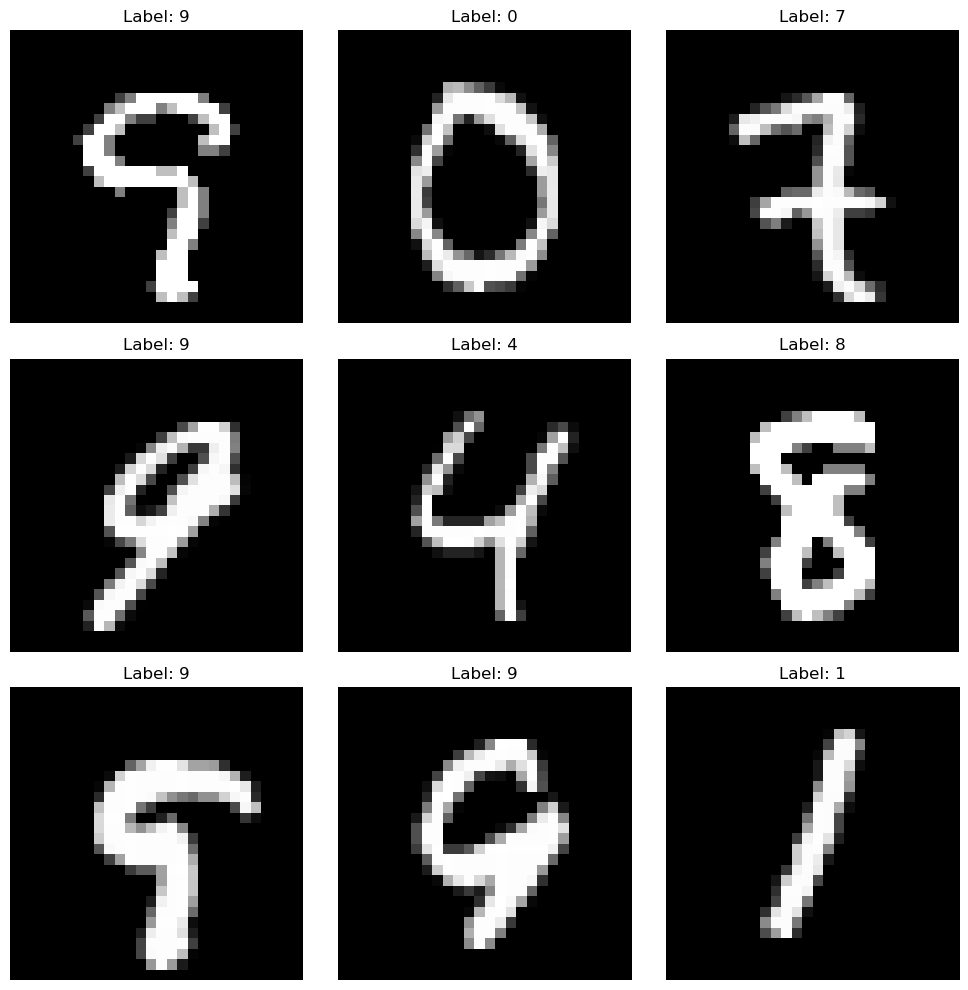

In [5]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

for row in range(3):
    for column in range(3):
        sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
        img, label = train_dataset[sample_idx]
        axs[row, column].imshow(img.squeeze(), cmap='gray')
        axs[row, column].set_title(f"Label: {label}")
        axs[row, column].axis('off')
plt.tight_layout()

## PART 1 : Classification with CNN on MNIST

### Architecture :  LeNet 

LeNet is the architecture described in the pratical session. It is one of the first CNN built by LeCun in the 1990's and proved well on MNIST despite simplicity. The architecture of the NN is the following : 
- Layer 1 : Convolution layer with 6 output channels and 5x5 filter (1x28x28 -> 6x24x24) 
- Layer 2 : Average pool of size 2x2 (6x24x24 -> 6x12x12)
- Layer 3 : Convolution with 16 outplut channels and 5x5 filter (6x12x12 -> 16x8x8)
- Layer 4 : Average pool of size 2x2 (16x8x8 -> 16x4x4 flattened to 256)
- Layer 5 : Fully connected (256 -> 84)
- Layer 6 : Fully connected (84 -> 10)

The activation function are ReLu except for a softmax activation used to output a probability distribution. 


In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.avgpool1 = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.avgpool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Define the network
        self.net = nn.Sequential(
            self.conv1, nn.ReLU(),
            self.avgpool1,
            self.conv2, nn.ReLU(),
            self.avgpool2, 
            nn.Flatten(),
            self.fc1, nn.ReLU(),
            self.fc2, nn.ReLU(),
            self.fc3,
            nn.Softmax(dim = 1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
model = LeNet()
model.to(device)
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)

### Training and evaluation

We now train the our model on the MNIST dataset using crossentropy loss : $$\mathcal{L}(p_{data},p_\theta) = -\mathbb{E}_{X \sim p_{data}}[\log(p_\theta(X))]$$
Here the model's output on an entry $x$ is the distribution over the labels conditionned on $x$, $p_\theta(c | x)$. The loss compares this output with the onehot distribution of the labeled data.


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 10
avg_loss_list = []

def train_one_epoch():
    model.train()  # Set model to training mode
    running_loss = 0.0
    total_batches = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move both to device
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_batches += 1
        
    avg_loss = running_loss / total_batches
    avg_loss_list.append(avg_loss)


In [10]:
for epoch in range(epochs):
    train_one_epoch()

100%|██████████| 938/938 [00:06<00:00, 138.80it/s]


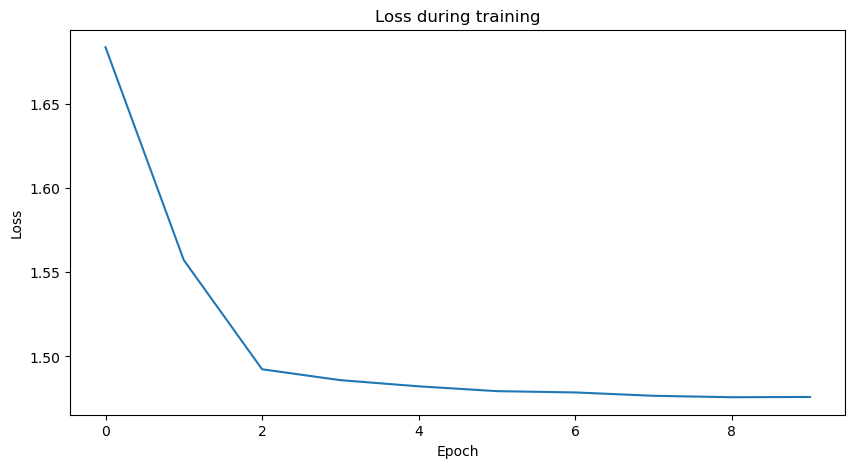

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(avg_loss_list)
ax.set_title("Loss during training")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()


In [12]:
def evaluate(): 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

evaluate()
            

Accuracy of the model on the 10000 test images: 98.62%


Per class accuracy :

Text(0.5, 1.0, 'Accuracy of the model for each class')

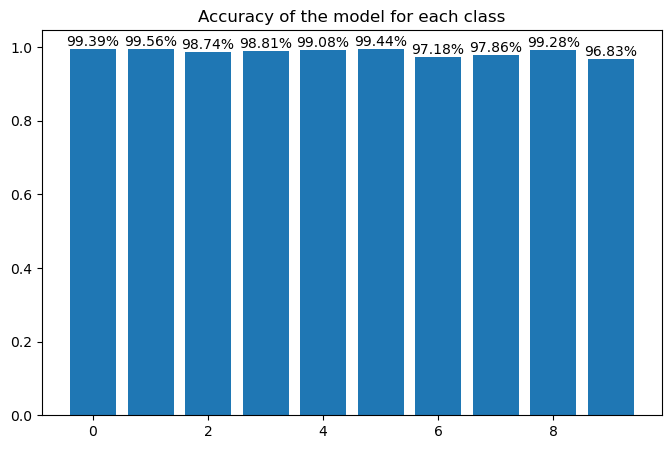

In [13]:
images = torch.stack([img for img, _ in test_dataset])
labels = torch.tensor([label for _, label in test_dataset])

accuracy = []

for key in range(10):
    inputs = images[labels == key]
    inputs_labels = torch.zeros(len(inputs)) + key
    predicted_labels = torch.argmax(model(inputs.to(device)), dim = 1)
    success_rate = (predicted_labels == inputs_labels.to(device)).float().mean().item()
    accuracy.append(success_rate)

fig, ax = plt.subplots(figsize = (8,5))
ax.bar(range(10), accuracy)
for i, v in enumerate(accuracy):
    ax.text(i, v, f'{v:.2%}', ha='center', va='bottom')
ax.set_title("Accuracy of the model for each class")


## PART 2 : Generation of adverserial examples

### Definition of the method

In this section we implement the Fast Gradient Sign Attack (FGSA) which consist in adding noise to the data in the direction of the directions given by the gradient of the cost function: 
\begin{equation}
    x_{adv}  = x + \epsilon \text{sign}(\nabla_x J(x,y))
\end{equation}
where $\epsilon$ is a parameter to tune.

In [14]:
def generate_adverserial_examples(model, criterion, image, label, epsilon, batch = True):
    """
    Generate adversarial examples using Fast Gradient Sign Method (FGSM)
    """
    model.eval()
    if not batch : 
        input = image.unsqueeze(0).to(device)  # (1, 1, 28, 28)
        if torch.is_tensor(label):
            target = label.to(device).long().unsqueeze(0) if label.dim() == 0 else label.to(device).long()
        else:
            target = torch.tensor([label], device=device, dtype=torch.long)
    else : 
        input = image.to(device)
        target = label.to(device).long()

    input.requires_grad_(True)
    
    output = model(input)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()

    noise = input.grad.sign()
    
    # Create adversarial example
    x_adv = input + epsilon * noise
    x_adv = torch.clamp(x_adv, -1.0, 1.0)

    if not batch : 
        return x_adv.detach().squeeze(0), noise.detach().squeeze(0)
    else : 
        return x_adv.detach(), noise.detach()


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

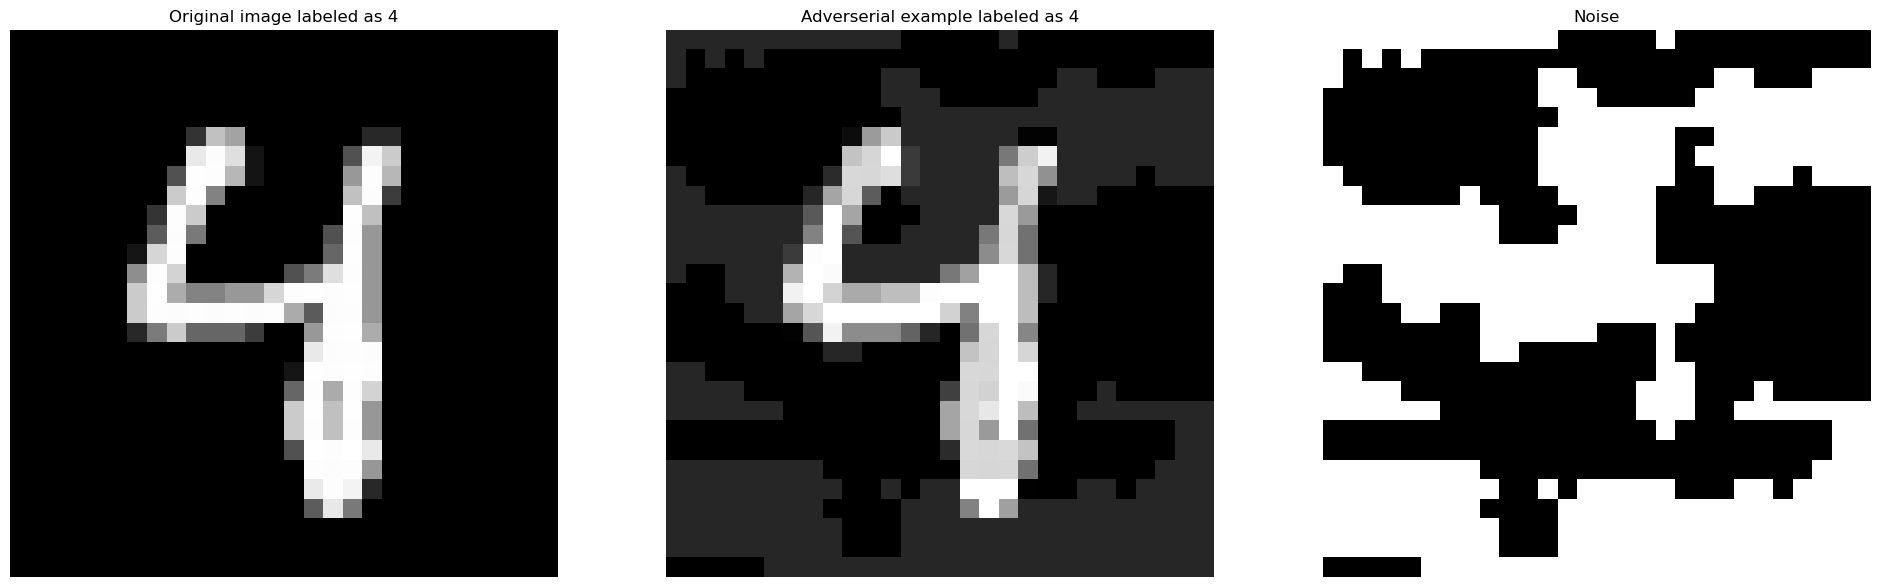

In [15]:
sample_idx = torch.randint(len(test_dataset), size=(1,)).item()
img, label = test_dataset[sample_idx]

img_adv, noise = generate_adverserial_examples(model, criterion, img, label, 0.3, batch = False)

img_adv = img_adv.to(device)
label_adv = torch.argmax(model(img_adv.unsqueeze(0))).item()

fig, axs = plt.subplots(1,3, figsize = (24,12))
axs[0].imshow(img.cpu().squeeze(), cmap='gray')
axs[0].set_title(f"Original image labeled as {label}")
axs[0].axis('off')
axs[1].imshow(img_adv.cpu().squeeze(), cmap='gray')
axs[1].set_title(f"Adverserial example labeled as {label_adv}")
axs[1].axis('off')
axs[2].imshow(noise.cpu().squeeze(), cmap='gray')
axs[2].set_title(f"Noise")
axs[2].axis('off')


Test of the function on a full batch :

Attack success rate: 39.30%


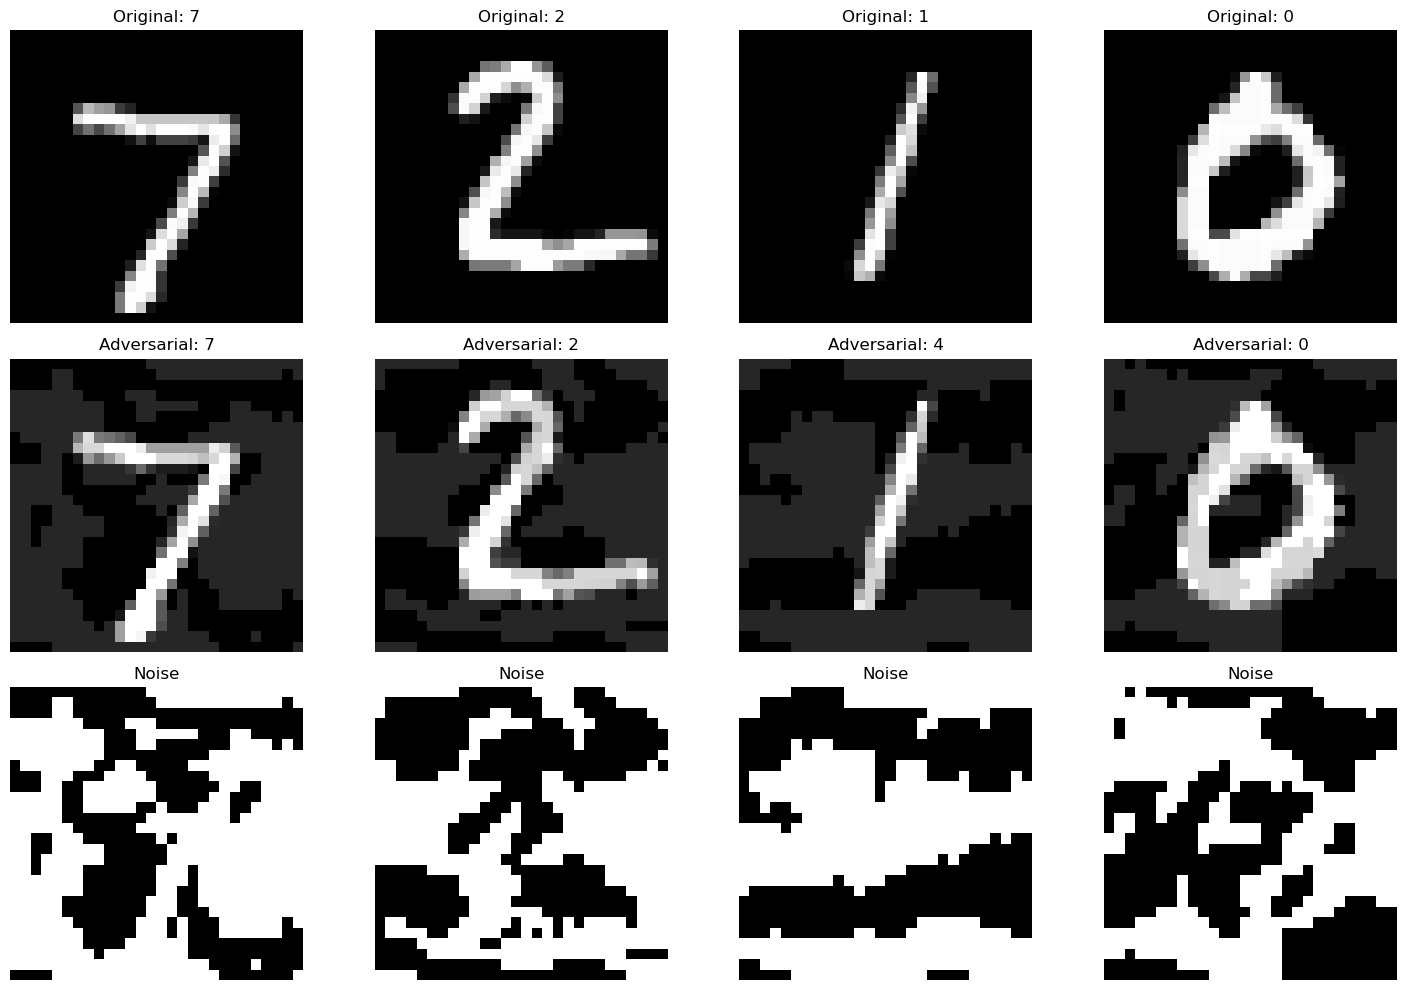

In [16]:

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Generate adversarial examples for the whole batch
adv_images, noises = generate_adverserial_examples(model, criterion, images, labels, epsilon=0.3, batch=True)

with torch.no_grad():
    orig_outputs = model(images.to(device))
    adv_outputs = model(adv_images.to(device))
    
    orig_preds = torch.argmax(orig_outputs, dim=1)
    adv_preds = torch.argmax(adv_outputs, dim=1)

# Calculate success rate of attack
success_rate = (orig_preds != adv_preds).float().mean().item()
print(f"Attack success rate: {success_rate*100:.2f}%")


fig, axs = plt.subplots(3, 4, figsize=(15, 10))
for i in range(4):
    axs[0,i].imshow(images.cpu()[i].squeeze(), cmap='gray')
    axs[0,i].set_title(f'Original: {labels[i].item()}')
    axs[0,i].axis('off')

    axs[1,i].imshow(adv_images.cpu()[i].squeeze(), cmap='gray')
    axs[1,i].set_title(f'Adversarial: {adv_preds[i].item()}')
    axs[1,i].axis('off')
    
    axs[2,i].imshow(noises.cpu()[i].squeeze(), cmap='gray')
    axs[2,i].set_title('Noise')
    axs[2,i].axis('off')

plt.tight_layout()


### Visualization of $\epsilon$'s influence

Visually, the greater $\epsilon$ is, the more noise is added to the image, the more the image is deteriorated and the les readable is the digit. It also makes the attack easier to detect by sight.

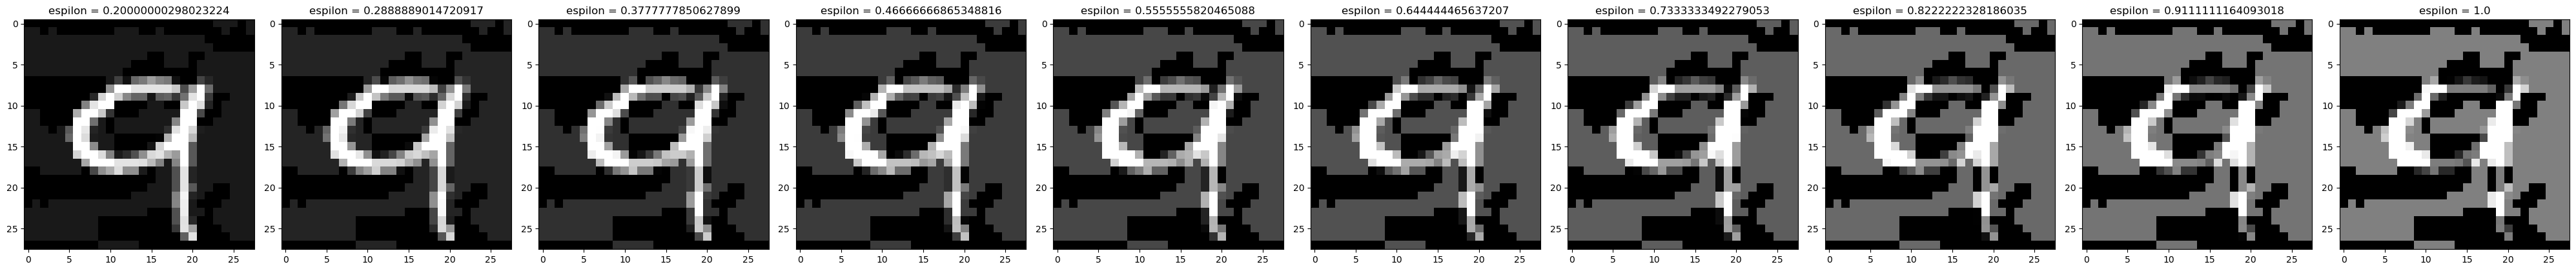

In [17]:
epsilons = torch.linspace(0.2, 1, 10)
sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
image, label = train_dataset[sample_idx]

fig, axs = plt.subplots(1, 10, figsize = (40, 10))

for i in range(len(epsilons)) :
    e = epsilons[i].item() 
    adv_images, _ = generate_adverserial_examples(model, criterion, image, label, e, batch = False)
    axs[i].imshow(adv_images.cpu().squeeze(0), cmap = "gray")
    axs[i].set_title(f"espilon = {e}")
    
plt.tight_layout()


## PART 3 : Statistics on the method

In this section we study the impact of the parameter $\epsilon$ on classification error and we follow the evolution of this score class by class. We also compare the attack with a simple addition of white noise. 

### Statistics of the FSGA attack

In [18]:
images = torch.stack([img for img, _ in test_dataset])
labels = torch.tensor([label for _, label in test_dataset])

In [19]:
epsilons = torch.concat([torch.zeros(1), torch.linspace(0.2, 1, 50)])

evolution = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
    "total" :[]
}


for e in tqdm(epsilons): 
    for key in evolution.keys():
        inputs = images
        inputs_labels = labels
        if type(key) == int: 
            inputs = images[labels == key]
            inputs_labels = torch.zeros(len(inputs)) + key
        adv_images, _ = generate_adverserial_examples(model, criterion, inputs, inputs_labels, e, batch = True)
        adv_labels = torch.argmax(model(adv_images), dim = 1)
        success_rate = (adv_labels != inputs_labels.to(device)).float().mean().item()
        evolution[key].append(success_rate)
        

100%|██████████| 51/51 [00:13<00:00,  3.74it/s]


Text(0, 0.5, 'Success rate')

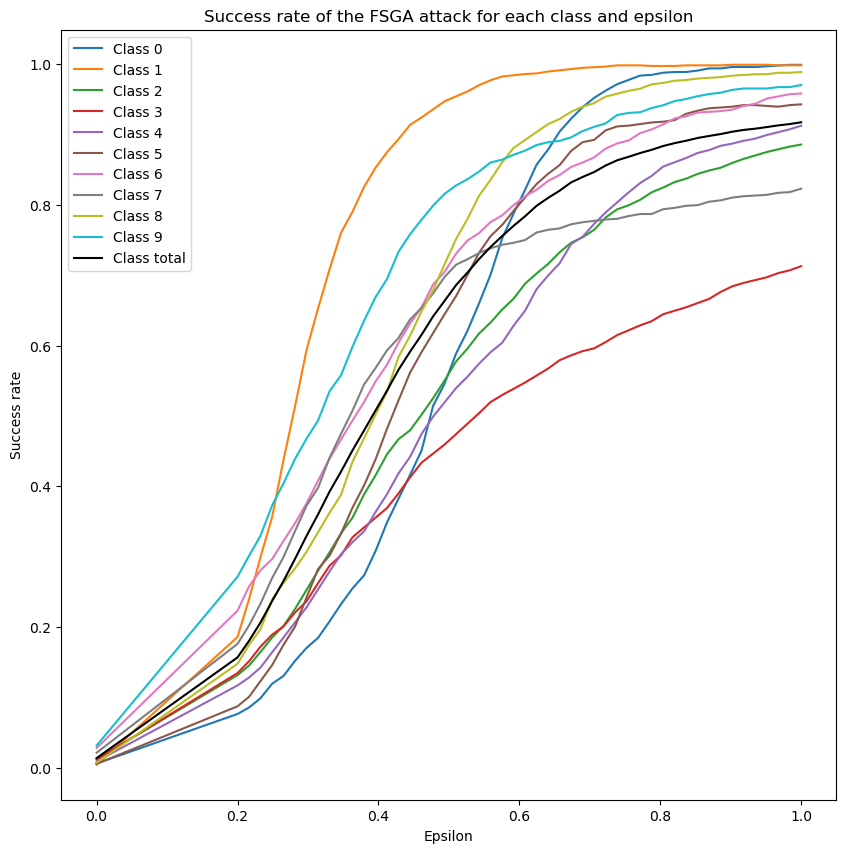

In [20]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']
for i, key in enumerate(evolution.keys()):
    ax.plot(epsilons, evolution[key], label = f"Class {key}", color=colors[i])
ax.legend()
ax.set_title("Success rate of the FSGA attack for each class and epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Success rate")

We observe that, as expected, the higher $\epsilon$, the higher the succes rate of the attack. Nonetheless, the FGSA does not perform equally on all classes. However, testing the procedure serval times shows that the classes that are most resistant change when retraining the model, the causes of randomness being the shuffling of the training dataset, the initialization of the neural networks parameter and the ADAM optimization procedure.

### Statistics of white noise addition attack

We now compare the FSGM attack with the simpler addition of white noise. Here $\epsilon$ corresponds to the standard deviation of the white noise.

In [21]:
def add_white_noise(image, epsilon):
    """
    Add white noise to the image.
    """
    noise = torch.randn_like(image) * epsilon
    return torch.clamp(image + noise, -1.0, 1.0), noise

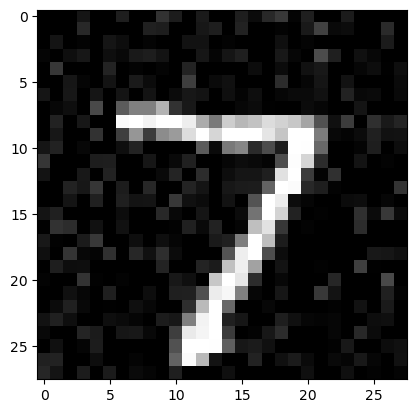

In [22]:
image = test_dataset[0][0]
plt.imshow(add_white_noise(image, 0.2)[0].cpu().squeeze(), cmap = "gray")

In [23]:
epsilons = torch.concat([torch.zeros(1), torch.linspace(0.2, 1, 50)])
N = 10  

evolution = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
    "total" :[]
}

for e in tqdm(epsilons):
    for key in evolution.keys():
        success_rates = []
        # We average over N trajectories to get a more stable result
        for _ in range(N):
            inputs = images
            inputs_labels = labels
            if type(key) == int:
                inputs = images[labels == key] 
                inputs_labels = torch.zeros(len(inputs)) + key
            adv_images, _ = add_white_noise(inputs, e)
            adv_labels = torch.argmax(model(adv_images.to(device)), dim = 1)
            success_rate = (adv_labels != inputs_labels.to(device)).float().mean().item()
            success_rates.append(success_rate)
        evolution[key].append(torch.mean(torch.tensor(success_rates)))

100%|██████████| 51/51 [01:30<00:00,  1.78s/it]


Text(0, 0.5, 'Success rate')

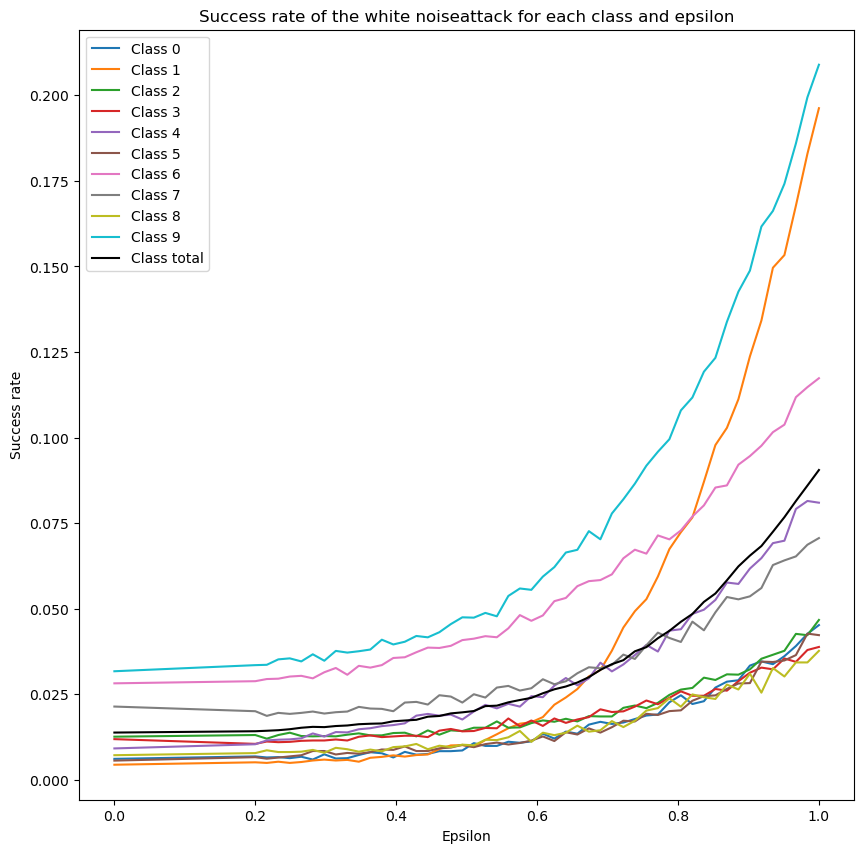

In [24]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']
for i, key in enumerate(evolution.keys()):
    ax.plot(epsilons, evolution[key], label = f"Class {key}", color=colors[i])
ax.legend()
ax.set_title("Success rate of the white noiseattack for each class and epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Success rate")

We see that overall the method performs poorly compared to the FSGA attack.

## PART 4 : Training on adverserial examples

In [25]:
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, mnist_dataset, epsilons):
        self.base_dataset = mnist_dataset
        self.epsilons = epsilons
        self.length = len(mnist_dataset) * (len(epsilons) + 1)  

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        base_idx = idx % len(self.base_dataset)
        img, label = self.base_dataset[base_idx]
        
        if idx < len(self.base_dataset):
            return img, label

        epsilon_idx = (idx // len(self.base_dataset)) - 1
        epsilon = self.epsilons[epsilon_idx]
        
        adv_img, _ = generate_adverserial_examples(model, criterion, img, label, epsilon, batch=False)
        adv_img = adv_img.cpu()  # Move back to CPU for DataLoader
        
        return adv_img, label


epsilons = torch.linspace(0.2, 1, 10)
mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
adv_train_dataset = AdversarialDataset(mnist_dataset, epsilons)


In [26]:
adv_train_loader = DataLoader(adv_train_dataset, batch_size=64, shuffle=True)

In [27]:
model_adv = LeNet()
model_adv.to(device)
model_adv

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)

In [28]:
optimizer_adv = optim.Adam(model_adv.parameters(), lr=0.001)

In [29]:
epochs = 10
avg_loss_list = []

def train_one_epoch():
    model_adv.train()  # Set model to training mode
    running_loss = 0.0
    total_batches = 0

    for i, data in tqdm(enumerate(adv_train_loader), total=len(adv_train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move both to device
        
        optimizer_adv.zero_grad()
        outputs = model_adv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_adv.step()

        running_loss += loss.item()
        total_batches += 1
        
    avg_loss = running_loss / total_batches
    avg_loss_list.append(avg_loss)

In [30]:
if not os.path.exists("model_adv.pth"):
    for epoch in range(epochs):
        train_one_epoch()
else:
    model_adv.load_state_dict(torch.load("model_adv.pth"))

100%|██████████| 10313/10313 [45:59<00:00,  3.74it/s]    


In [31]:
# Save the model
if not os.path.exists("model_adv.pth"):
    torch.save(model_adv.state_dict(), "model_adv.pth")

In [32]:
epsilons = torch.concat([torch.zeros(1), torch.linspace(0.2, 1, 50)])

evolution = {
    0 : [],
    1 : [],
    2 : [],
    3 : [],
    4 : [],
    5 : [],
    6 : [],
    7 : [],
    8 : [],
    9 : [],
    "total" :[]
}


for e in tqdm(epsilons): 
    for key in evolution.keys():
        inputs = images
        inputs_labels = labels
        if type(key) == int: 
            inputs = images[labels == key]
            inputs_labels = torch.zeros(len(inputs)) + key
        adv_images, _ = generate_adverserial_examples(model, criterion, inputs, inputs_labels, e, batch = True)
        adv_labels = torch.argmax(model_adv(adv_images), dim = 1)
        success_rate = (adv_labels != inputs_labels.to(device)).float().mean().item()
        evolution[key].append(success_rate)

100%|██████████| 51/51 [00:12<00:00,  3.96it/s]


Text(0, 0.5, 'Success rate')

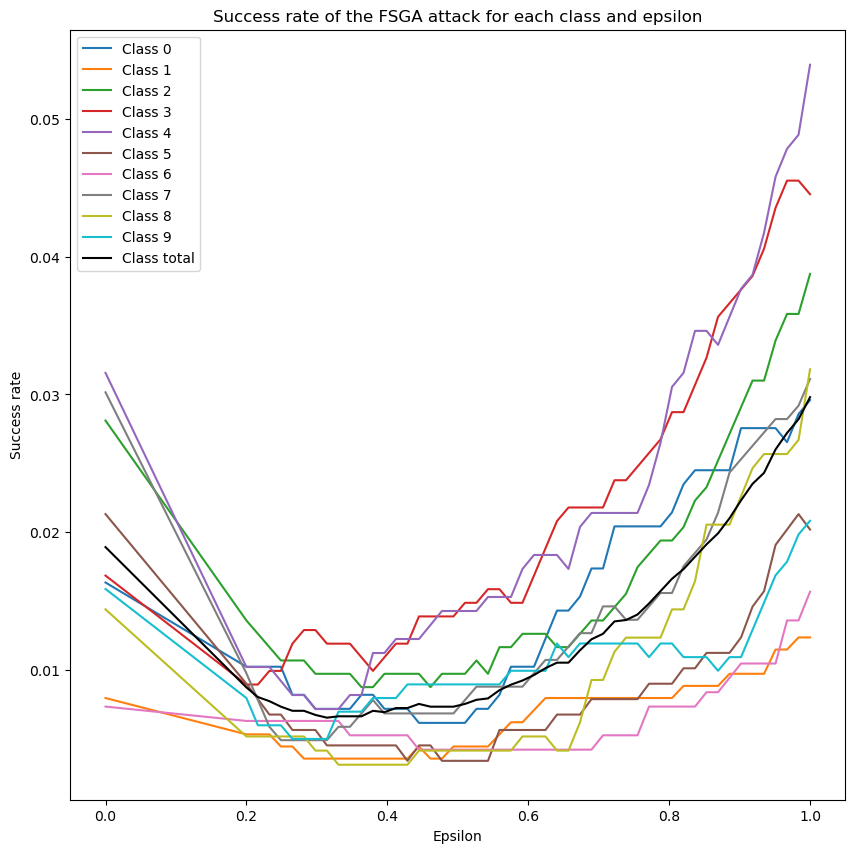

In [33]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']
for i, key in enumerate(evolution.keys()):
    ax.plot(epsilons, evolution[key], label = f"Class {key}", color=colors[i])
ax.legend()
ax.set_title("Success rate of the FSGA attack for each class and epsilon")
ax.set_xlabel("Epsilon")
ax.set_ylabel("Success rate")